In [1]:
!pip install -q -U pytorch-lightning datasets fsspec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.2/829.2 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 20.9 MB/s eta 0:00:00


In [2]:
import sys
import numpy as np
import torch
import pytorch_lightning as pl
import torch.nn as nn
from torchvision import models

from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef, roc_curve, auc, precision_recall_curve
import seaborn as sns
import matplotlib.pyplot as plt

from datasets import load_dataset

from google.colab import drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
PROJECT_PATH = "/content/drive/MyDrive/MyProject/brain-tumor-ai/Models/2D_Classifier_Multiclass"

CHECKPOINT_PATH = "/content/drive/MyDrive/MyProject/brain-tumor-ai/Models/2D_Classifier_Multiclass/checkpoint/best-finetune-epoch=53-val_loss=0.10.ckpt"

In [5]:
if PROJECT_PATH not in sys.path:
    sys.path.append(PROJECT_PATH)

In [6]:
from module import NN_PLmodule
from datamodule import DataModule

In [7]:
ds = load_dataset("Cayanaaa/BrainTumorDatasets", name="multiclass")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

multiclass/train-00000-of-00001.parquet:   0%|          | 0.00/130M [00:00<?, ?B/s]

multiclass/test-00000-of-00001.parquet:   0%|          | 0.00/25.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5712 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1311 [00:00<?, ? examples/s]

In [8]:
test_data = ds['test']
images = test_data['image']
labels = test_data['label']

In [9]:
print(ds['test'].features['label'].names)

['glioma', 'meningioma', 'notumor', 'pituitary']


In [10]:
labels_unique = np.unique(labels)
print(labels_unique)

[0 1 2 3]


In [11]:
type(images), type(labels)

(datasets.arrow_dataset.Column, datasets.arrow_dataset.Column)

In [12]:
data_module = DataModule(
    test_data = (images, labels),
    batch_size = 64,
    num_workers=2
)

In [13]:
backbone = models.densenet121(pretrained=True)
num_features = backbone.classifier.in_features
backbone.classifier = nn.Linear(num_features, 4)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 163MB/s]


In [14]:
criterion = nn.CrossEntropyLoss()

In [15]:
model = NN_PLmodule.load_from_checkpoint(CHECKPOINT_PATH, backbone=backbone, num_classes=4, strict=False)
model.set_criterion(criterion)

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.weight']


In [16]:
trainer = pl.Trainer(
    accelerator = "gpu",
    devices = 1
)

INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [17]:
trainer.test(model, data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.971860945224762     │
│        test_auroc         │    0.9972546696662903     │
│         test_loss         │    0.09135648608207703    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.09135648608207703,
  'test_acc': 0.971860945224762,
  'test_auroc': 0.9972546696662903}]

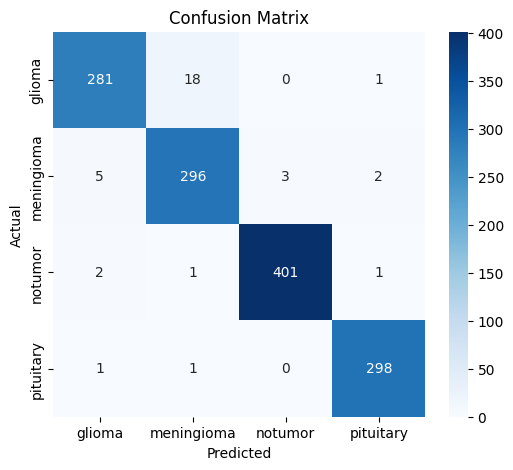


Classification Report:
              precision    recall  f1-score   support

      glioma     0.9723    0.9367    0.9542       300
  meningioma     0.9367    0.9673    0.9518       306
     notumor     0.9926    0.9901    0.9913       405
   pituitary     0.9868    0.9933    0.9900       300

    accuracy                         0.9733      1311
   macro avg     0.9721    0.9719    0.9718      1311
weighted avg     0.9736    0.9733    0.9733      1311


Macro-average AUROC: 0.9973
Mean Average Precision (mAP): 0.9925
Matthews Correlation Coefficient (MCC): 0.9643


In [18]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, average_precision_score, matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns

# Label names
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

all_probs = []
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for x, y in data_module.test_dataloader():
        x = x.to(model.device)
        outputs = model(x)  # logits shape [B, num_classes]
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        preds = np.argmax(probs, axis=1)

        all_probs.extend(probs)
        all_preds.extend(preds)
        all_labels.extend(y.cpu().numpy())

all_probs = np.array(all_probs)
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

# AUROC (Macro-average)
try:
    auroc_macro = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='macro')
    print(f"\nMacro-average AUROC: {auroc_macro:.4f}")
except ValueError:
    print("\nAUROC could not be computed (check class distribution).")

# Average Precision (mAP)
map_score = average_precision_score(all_labels, all_probs, average='macro')
print(f"Mean Average Precision (mAP): {map_score:.4f}")

# Matthews Correlation Coefficient
mcc = matthews_corrcoef(all_labels, all_preds)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")
